In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import torch
from torch import nn
from torch.nn import Module
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder

In [ ]:
rating_path = '/content/drive/MyDrive/movielens_100k/ml-100k/u.data'
item_path = '/content/drive/MyDrive/movielens_100k/ml-100k/u.item'
user_path = '/content/drive/MyDrive/movielens_100k/ml-100k/u.user'

In [ ]:
df_rating = pd.read_csv(rating_path, sep='\t', header=None, names=['user_id', 'movie_id', 'rating', 'timestamp'])

In [ ]:
user_le = LabelEncoder()
item_le = LabelEncoder()
df_rating['user_id_idx'] = user_le.fit_transform(df_rating['user_id'].values)
df_rating['item_id_idx'] = item_le.fit_transform(df_rating['movie_id'].values)
num_users = df_rating['user_id'].unique().shape[0]
num_items = df_rating['movie_id'].unique().shape[0]

In [ ]:
mu = torch.tensor(df_rating['rating'].mean())
mu

tensor(3.5299, dtype=torch.float64)

In [ ]:
from torch.utils.data import Dataset

class MovielensDataset(Dataset):
    """MovieLens dataset"""
    
    def __init__(self,data, train = False, test_ratio = 0.1):
        self.data = data
        self.train = train
        self.test_ratio = test_ratio
        
        # split data
        self.train_data, self.test_data = self.split_train_test_data(self.data,
                                                                     test_ratio)
        
        # train/test confirmed
        if self.train == True:
            self.data = self.train_data
        else:
            self.data = self.test_data
            
        # set user, item, rating    
        self.users = torch.tensor(self.data['user_id_idx'].values) 
        self.items = torch.tensor(self.data['item_id_idx'].values)
        self.ratings = torch.tensor(self.data['rating'].values) 
    

    def split_train_test_data(self, data, test_ratio = 0.1):
        """
        train_test_split(data test_size train_size, stratify = self.df['user_id_idx'].values)로 대체 가능
        stratify -> Label별 sampling 
        """
        user_id_uniq = self.data.user_id.unique()
        mask = []
        for i in user_id_uniq:
            data_user = self.data[self.data['user_id'] == i]
            mask.extend([True if x==1 else False for x in np.random.uniform(0,1,len(data_user))<1-test_ratio])
        neg_mask = [not x for x in mask]
        train_data, test_data = data[mask], data[neg_mask]
        return train_data, test_data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        users = self.users[idx]
        items = self.items[idx]
        ratings = self.ratings[idx]
        return (users, items, ratings.float())

In [ ]:
class MF(Module):
    """MF"""
    
    def __init__(self, num_factors, num_users, num_items, mu):
        super(MF,self).__init__()
        # set latent matrix shape
        self.P = nn.Embedding(num_users, num_factors)
        self.Q = nn.Embedding(num_items, num_factors)
        
        # set bias shape
        self.user_bias = nn.Embedding(num_users,  1)
        self.item_bias = nn.Embedding(num_items,  1)
        
        self.mu = mu
        
    def forward(self, user_id, item_id):
        P_u = self.P(user_id)
        Q_i = self.Q(item_id)
        b_u = self.user_bias(user_id)
        b_i = self.item_bias(item_id)
        mu = self.mu
        outputs = torch.sum((P_u*Q_i),axis = 1) + torch.squeeze(b_u) + torch.squeeze(b_i) + mu
        
        return outputs.flatten()

In [ ]:
def train(model, trian_iter, loss, optm, device):
    model.train()
    loss_sum = 0
    
    for users, items, ratings in trian_iter:
        users = users.to(device)
        items = items.to(device)
        ratings = ratings.to(device)
        
        preds = model(users, items)
        loss_out = loss(preds, ratings)
        
        # update
        optm.zero_grad()
        loss_out.backward()
        optm.step()
        
        loss_sum += loss_out.item()
    
    loss_avg = loss_sum/len(trian_iter)
    
    return loss_avg

In [ ]:
def evaluate(model, test_iter, device):    
    with torch.no_grad():
        model.eval()
        loss = nn.MSELoss()
        loss_sum = 0
        
        for idx, (users,items,ratings) in enumerate(test_iter):
            users = users.to(device)
            items = items.to(device)
            ratings = ratings.to(device)
            
            preds = model(users, items)
            
            loss_out = loss(preds, ratings)
            
            loss_sum += loss_out.item()

    loss_avg = loss_sum / len(test_iter)
    
    return loss_avg

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') # device 설정

num_factors = 30 # Latent factor 수
batch_size = 128 # 배치사이즈
epochs = 31 # 에포크 수
lr = 0.005 # 학습률

device

device(type='cpu')

In [ ]:
from torch.utils.data import DataLoader

# train/test data 불러오기 by Dataset&Dataloader
train_dataset = MovielensDataset(data = df_rating, train = True)
test_dataset = MovielensDataset(data = df_rating, train = False)

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

In [ ]:
# 모델 객체 생성 
model = MF(num_factors, num_users, num_items, mu).to(device)
loss = nn.MSELoss() # loss 객체
optm = torch.optim.Adam(model.parameters(), lr = lr) # optimizer 객체

epoch: 0, train Loss: 22.5346, test Loss: 11.6903
epoch: 5, train Loss: 1.0685, test Loss: 0.9603
epoch: 10, train Loss: 0.6164, test Loss: 0.6248
epoch: 15, train Loss: 0.4827, test Loss: 0.5204
epoch: 20, train Loss: 0.4030, test Loss: 0.4591
epoch: 25, train Loss: 0.3571, test Loss: 0.4357
epoch: 30, train Loss: 0.3284, test Loss: 0.4192


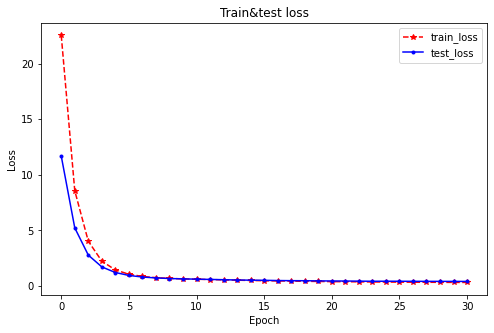

In [ ]:
# 학습
train_losses = []
test_losses = []

for epoch in range(epochs):

    train_loss = train(model, train_loader, loss, optm, device)
    test_loss = evaluate(model, test_loader, device)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    if epoch%5==0:
        print(f'epoch: {epoch}, train Loss: {train_loss:.4f}, test Loss: {test_loss:.4f}')

        
# 그래프
fig, ax = plt.subplots(1,1, figsize = (8,5))

ax.plot(train_losses, label = 'train_loss',
       color = 'red',
       marker = '*',
       linestyle = '--')
ax.plot(test_losses, label = 'test_loss',
       color = 'blue',
       marker = '.')

ax.set_title('Train&test loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
plt.show()